In [58]:
!pip install fuzzywuzzy

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('train.csv')

In [6]:
new_df = df.sample(30000,random_state=2)

In [7]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [8]:
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replacing certain special characters
    q = q.replace('%','percent')
    q = q.replace('$','dollar')
    q = q.replace('₹','rupee')
    q = q.replace('€','euro')
    q = q.replace('@','at')
    
    # The 'math' appeared around 900 times in the whole dataset
    q = q.replace('math'," ")
    
    # Replacing some numbers with string 
    q = q.replace(',000,000,000','b')
    q = q.replace(',000,000','m')
    q = q.replace('000','k')
    
    
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    q_decontracted = []
    
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        
        q_decontracted.append(word)
        
    
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't",' not')
    q = q.replace("'re",' are')
    q = q.replace("'ll",' will')
    
    # Remove HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove Punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ',q).strip()
    
    return q

In [9]:
preprocess("I've aleready! done it<b>")

'i have aleready  done it'

In [10]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [11]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


# Feature Engineering 

In [12]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [13]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [14]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [15]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [16]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [17]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [18]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


# Advanced Features

In [19]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0]*8
    
    #converting senetne into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens)== 0 or len(q2_tokens) ==0:
        return token_features
    
    # Get the non-stopwords in questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in questions 
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non stopwords from question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question pairs
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the comon tokens from question pairs
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words),len(q2_words)) +SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words),len(q2_words)) +SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops),len(q2_stops)) +SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops),len(q2_stops)) +SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens),len(q2_tokens)) +SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens),len(q2_tokens)) +SAFE_DIV)
    
    # Last word of both question is same or not 
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First wprd of both question is same or not 
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [20]:
token_features = new_df.apply(fetch_token_features,axis=1)

new_df['cwc_min']          = list(map(lambda x : x[0],token_features))
new_df['cwc_max']          = list(map(lambda x : x[1],token_features))
new_df['csc_min']          = list(map(lambda x : x[2],token_features))
new_df['csc_max']          = list(map(lambda x : x[3],token_features))
new_df['ctc_min']          = list(map(lambda x : x[4],token_features))
new_df['ctc_max']          = list(map(lambda x : x[5],token_features))
new_df['last_word_eq']     = list(map(lambda x : x[6],token_features))
new_df['first_word_eq']    = list(map(lambda x : x[7],token_features))


In [21]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [22]:
# Length featuers
import distance

def fetch_length_featuers(row):
    q1 = row['question1']
    q2 = row['question2']
    
    length_featuers = [0.0]*3
    
    # converting the senetcnce into tokens
    q1_token = q1.split()
    q2_token = q2.split()
    
    if len(q1_token) == 0 or len(q2_token)==0:
        return length_featuers
    
    # Absolute length featuers
    length_featuers[0] = abs(len(q1_token) - len(q2_token))
    
    # Average token lentgh of both questions
    length_featuers[1] = (len(q1_token)+len(q2_token))/2
    
    strs = list(distance.lcsubstrings(q1,q2))
    length_featuers[2] = len(strs[0])/(min(len(q1),len(q2))+1)
    
    return length_featuers

In [23]:
length_featuers = new_df.apply(fetch_length_featuers,axis=1)

new_df['abs_len_diff'] = list(map(lambda x :x[0],length_featuers))
new_df['mean_len'] = list(map(lambda x :x[1],length_featuers))
new_df['longest_sbstr_ratio'] = list(map(lambda x :x[2],length_featuers))

In [24]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_sbstr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.542857


In [25]:
#Fuzzy Features 
from fuzzywuzzy import fuzz

def fetch_fuzzy_featuers(row):
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_featuers = [0.0]*4
    
    # Fuzzy ratio
    fuzzy_featuers[0] = fuzz.QRatio(q1,q2)
    
    # Fuzzy partial ratio
    fuzzy_featuers[1] = fuzz.partial_ratio(q1,q2)
    
    # Fuzzy_sort ratio
    fuzzy_featuers[2] = fuzz.token_sort_ratio(q1,q2)

    # Fuzzy set ration
    fuzzy_featuers[3] = fuzz.token_set_ratio(q1,q2)
    
    return fuzzy_featuers

In [26]:
fuzzy_fetuers = new_df.apply(fetch_fuzzy_featuers,axis=1)

new_df['fuzz_ratio'] = list(map(lambda x :x[0],fuzzy_fetuers))
new_df['fuzz_partial_ratio'] = list(map(lambda x :x[1],fuzzy_fetuers))
new_df['fuzz_sort_ratio'] = list(map(lambda x :x[2],fuzzy_fetuers))
new_df['fuzz_set_ratio'] = list(map(lambda x :x[3],fuzzy_fetuers))

In [27]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_sbstr_ratio,fuzz_ratio,fuzz_partial_ratio,fuzz_sort_ratio,fuzz_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


In [28]:
new_df.shape

(30000, 28)

## EDA

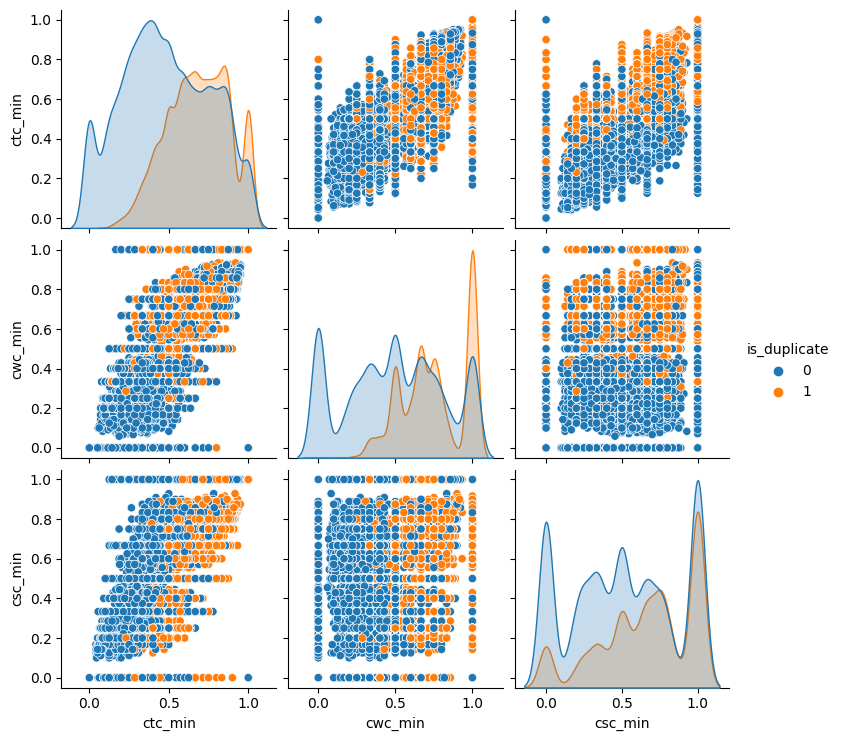

In [29]:
sns.pairplot(new_df[['ctc_min','cwc_min','csc_min','is_duplicate']],hue='is_duplicate')

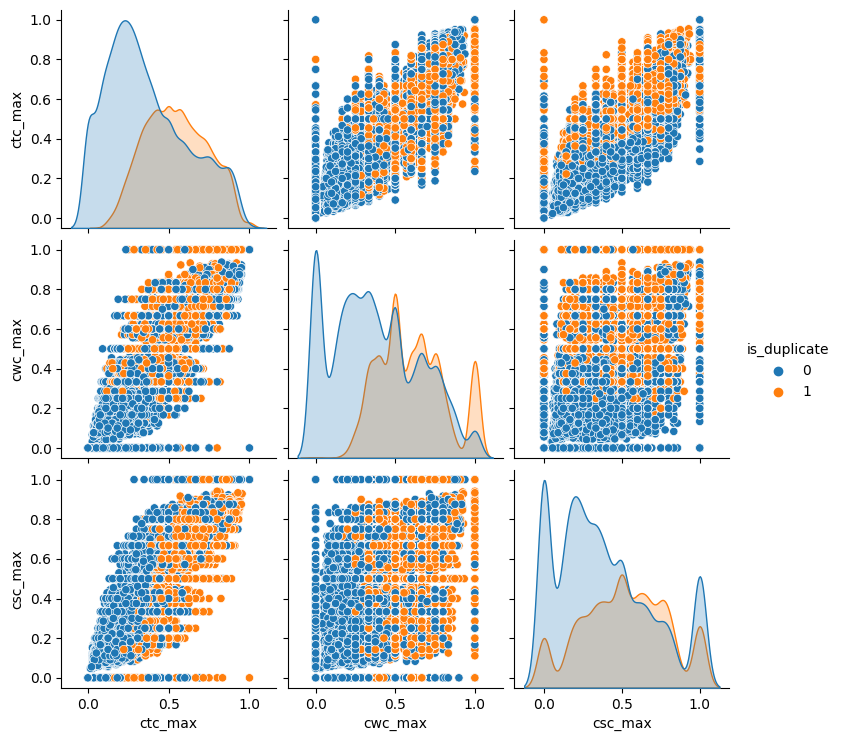

In [30]:
sns.pairplot(new_df[['ctc_max','cwc_max','csc_max','is_duplicate']],hue='is_duplicate')

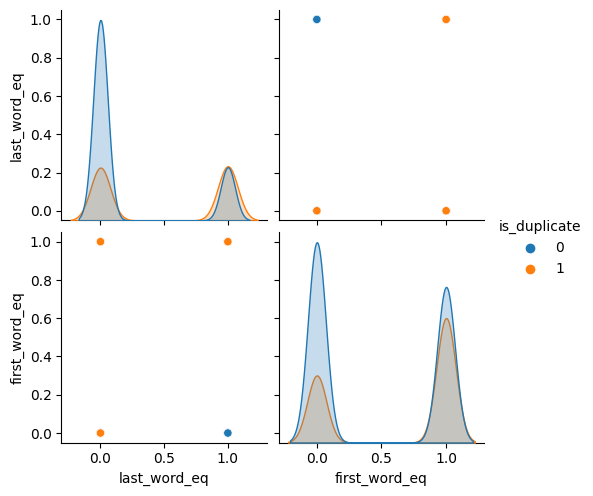

In [31]:
sns.pairplot(new_df[['last_word_eq','first_word_eq','is_duplicate']],hue='is_duplicate')

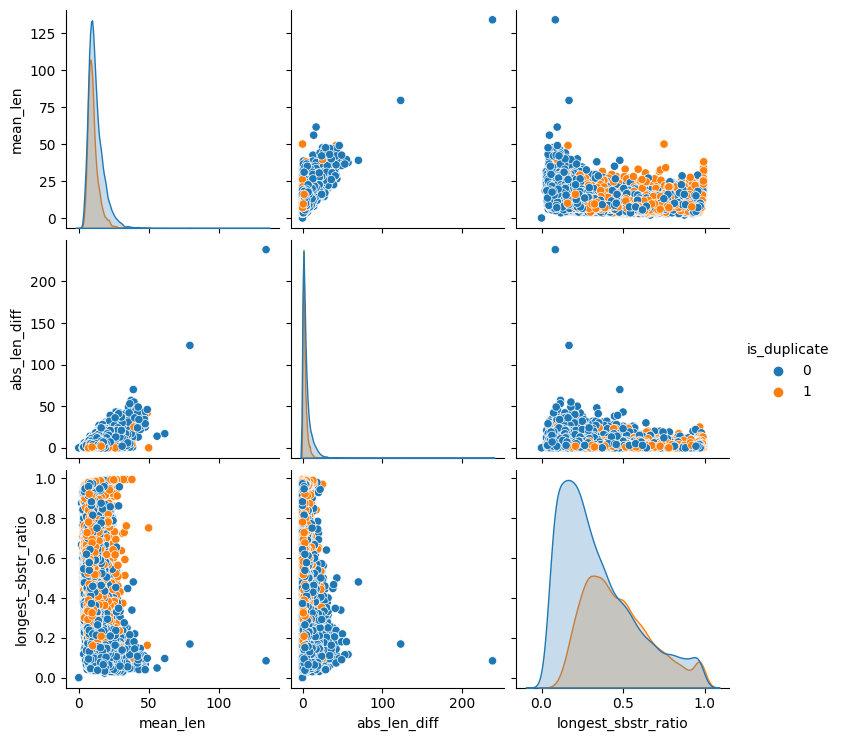

In [32]:
sns.pairplot(new_df[['mean_len','abs_len_diff','longest_sbstr_ratio','is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(new_df[['fuzz_ratio','fuzz_partial_ratio','fuzz_sort_ratio','fuzz_set_ratio','is_duplicate']],hue='is_duplicate')

## Modeling

In [ ]:
ques_df = new_df[['question1','question2']]
ques_df.head()

In [ ]:
final_df =new_df.drop(columns=['id','qid1','qid2','question1','question2'])
final_df.shape

In [ ]:
final_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_df['question1'])+list(ques_df['question2'])
cv = CountVectorizer(max_features=3000)
q1_arr,q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
pickle.dump(cv,open('cv.pkl','wb'))

In [35]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [36]:
final_df = pd.concat([final_df,temp_df],axis=1)

final_df.shape

(30000, 6023)

In [37]:
final_df.to_csv('final_data.csv')

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,random_state=1,test_size=0.2)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test,y_pred)

0.7826666666666666

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_pred1 = xgb.predict(x_test)
accuracy_score(y_test,y_pred1)

0.791

### Confusion matrics

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(y_test,y_pred)           ### for rf

array([[3269,  543],
       [ 761, 1427]], dtype=int64)

In [44]:
confusion_matrix(y_test,y_pred1)                 ### for xgb

array([[3245,  567],
       [ 687, 1501]], dtype=int64)

In [46]:
import pickle
pickle.dump(rf,open('model_rf.pkl','wb'))

In [2]:
import pickle 